In [ ]:
!pip install -q albumentations opencv-python joblib


In [ ]:
!pip install -q ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision import models, transforms


In [ ]:
scaler = joblib.load("depth_scaler.pkl")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load YOLOv8 dent model
yolo_model = YOLO("best_recall.pt")  # <-- your weights
yolo_model.to("cuda" if torch.cuda.is_available() else "cpu")


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
def get_detector(num_classes=2):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128, 256),) * 5,
        aspect_ratios=((0.3, 0.5, 1.0, 2.0, 3.0),) * 5
    )

    model.rpn.anchor_generator = anchor_generator
    model.rpn.head = RPNHead(
        model.backbone.out_channels,
        anchor_generator.num_anchors_per_location()[0]
    )

    model.rpn.pre_nms_top_n_test = 3000
    model.rpn.post_nms_top_n_test = 1500

    model.roi_heads.nms_thresh = 0.3
    model.roi_heads.score_thresh = 0.05
    model.roi_heads.detections_per_img = 200

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
detector = get_detector().to(device)
detector.load_state_dict(torch.load("RCNN_Best.pth", map_location=device))
detector.eval()


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 189MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
class DentRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")
        for p in self.backbone.parameters():
            p.requires_grad = False
        for p in self.backbone.layer4.parameters():
            p.requires_grad = True

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.regressor = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.regressor(self.backbone(x))


In [ ]:
depth_model = DentRegressor().to(device)
depth_model.load_state_dict(torch.load("best_model.pth", map_location=device))
depth_model.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


DentRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
from scipy.stats import kurtosis

def compute_aux_labels(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)

    bright = int(np.mean(v > 230) > 0.02)
    specular = int(np.mean((v > 240) & (grad_mag < grad_mag.mean())) > 0.005)

    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).flatten()
    hist /= hist.sum() + 1e-6
    sharp_peak = int(kurtosis(hist) > 8)

    depth_grad = int(np.var(grad_mag) > 50)

    h,w = gray.shape
    yy,xx = np.indices((h,w))
    r = np.sqrt((xx-w/2)**2 + (yy-h/2)**2)
    r /= r.max() + 1e-6
    corr = np.corrcoef(r.flatten(), gray.flatten())[0,1]
    radial = int(abs(corr) > 0.15)

    return (bright, specular, sharp_peak, depth_grad, radial)


In [ ]:
class DentResNetWithAux(nn.Module):
    def __init__(self, num_aux=5):
        super().__init__()
        self.backbone = models.resnet18(weights="IMAGENET1K_V1")
        self.backbone.fc = nn.Identity()

        self.fc_img = nn.Linear(512, 128)
        self.fc_aux = nn.Sequential(
            nn.Linear(num_aux, 32),
            nn.ReLU()
        )
        self.fc_out = nn.Linear(160, 1)

    def forward(self, img, aux):
        img_feat = self.fc_img(self.backbone(img))
        aux_feat = self.fc_aux(aux)
        return self.fc_out(torch.cat([img_feat, aux_feat], dim=1))


In [ ]:
dent_classifier = DentResNetWithAux().to(device)
dent_classifier.load_state_dict(torch.load("yes_no_model.pth", map_location=device))
dent_classifier.eval()


DentResNetWithAux(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
depth_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2()
])


In [ ]:
clf_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])


In [ ]:
@torch.no_grad()
def detect_and_crop(img_path, conf_thresh=0.1):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape

    results = yolo_model(img_rgb, conf=conf_thresh, verbose=False)[0]

    crops = []
    boxes = []

    if results.boxes is None:
        return img_rgb, crops, boxes

    for box in results.boxes:
        cls = int(box.cls.item())
        conf = box.conf.item()

        # If multiple classes exist, filter dent class here
        # if cls != 0: continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1 = max(0,x1), max(0,y1)
        x2, y2 = min(W,x2), min(H,y2)

        crop = img_rgb[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        crops.append(crop)
        boxes.append((x1,y1,x2,y2))

    return img_rgb, crops, boxes


In [ ]:
@torch.no_grad()
def is_real_dent(crop, thresh=0.5):
    img = clf_tfms(crop).unsqueeze(0).to(device)
    aux = torch.tensor(
        compute_aux_labels(cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)),
        dtype=torch.float32
    ).unsqueeze(0).to(device)

    prob = torch.sigmoid(dent_classifier(img, aux)).item()
    return prob >= thresh, prob


In [ ]:
@torch.no_grad()
def predict_depth(crop):
    t = depth_tfms(image=crop)["image"].unsqueeze(0).to(device)
    pred_scaled = depth_model(t).cpu().numpy()
    return scaler.inverse_transform(pred_scaled)[0][0]


In [ ]:
def run_pipeline(image_path):
    img, crops, boxes = detect_and_crop(image_path)

    dent_id = 0
    for crop, box in zip(crops, boxes):
        ok, prob = is_real_dent(crop)
        if not ok:
            continue

        dent_id += 1
        depth = predict_depth(crop)

        x1,y1,x2,y2 = box
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
        cv2.putText(
            img,
            f"Dent {dent_id} | {depth:.2f}mm",
            (x1,y1-5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,(255,0,0),1
        )

        print(f"Dent {dent_id}: depth={depth:.2f} mm | prob={prob:.2f}")

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


Dent 1: depth=1.81 mm | prob=1.00


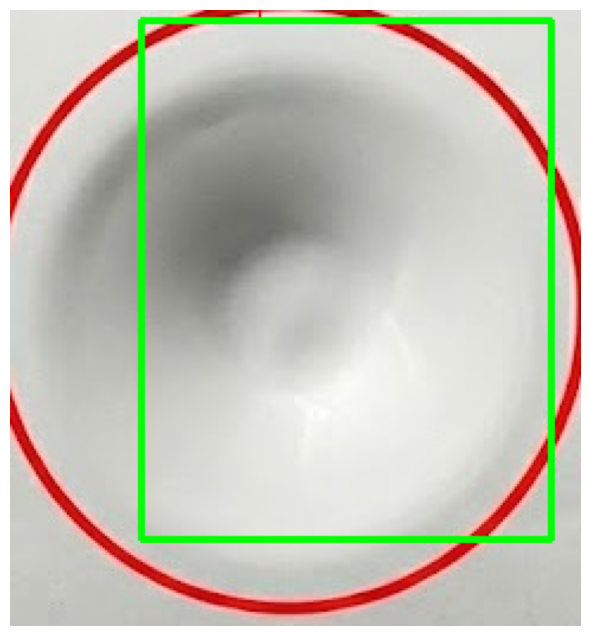

In [ ]:
run_pipeline("/content/test_5.jpeg")

Dent 1: depth=1.52 mm | prob=0.99


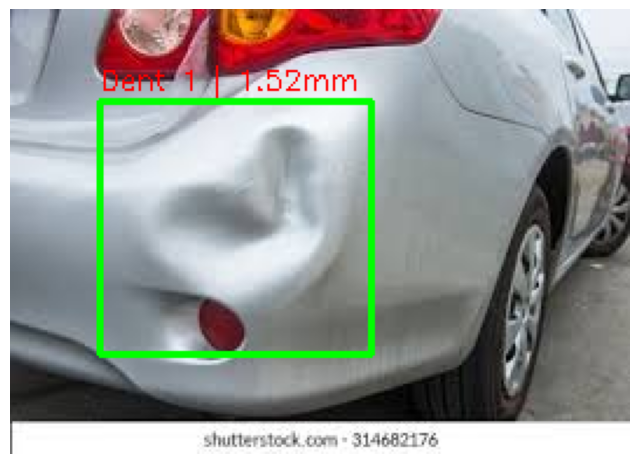

In [ ]:
run_pipeline("/content/test.jpg")

In [ ]:
def run_pipeline(image_path):
    img, crops, boxes = detect_and_crop(image_path)

    real_dents_data = []
    for crop, box in zip(crops, boxes):
        ok, prob = is_real_dent(crop)
        if ok:
            real_dents_data.append({'prob': prob, 'crop': crop, 'box': box})

    if not real_dents_data:
        print("No real dents found.")
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.axis("off")
        plt.title("No real dents found")
        plt.show()
        return

    most_probable_dent = max(real_dents_data, key=lambda x: x['prob'])

    crop = most_probable_dent['crop']
    box = most_probable_dent['box']
    prob = most_probable_dent['prob']

    depth = predict_depth(crop)

    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
    cv2.putText(
        img,
        f"Dent | {depth:.2f}mm",
        (x1,y1-5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.4,(255,0,0),1
    )

    print(f"Selected Dent: depth={depth:.2f} mm | probability={prob:.2f}")

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

No real dents found.


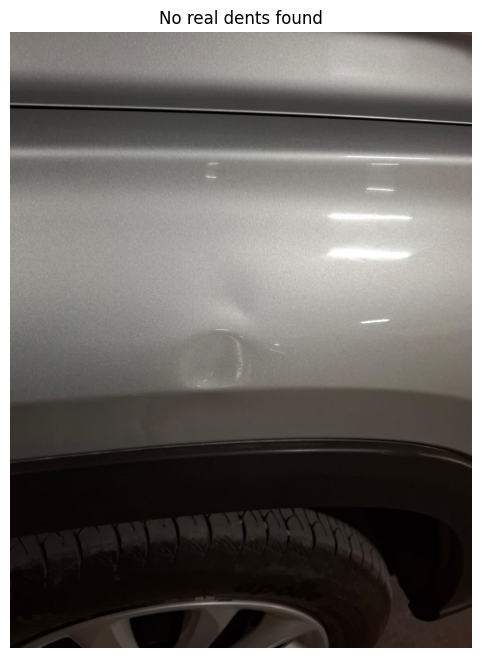

In [ ]:
run_pipeline("/content/new_dent.jpeg")